In [1]:
from torch import nn
import torch
from torch import optim
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from ssapp.data import AntennaDatasetLoaders

cut_folder, log_file = AntennaDatasetLoaders.get_raw_dataset_path('ReflectorAntennaSimpleDataset1')

print(cut_folder)

c:\Users\Niels\OneDrive\Documents\GitHub\Supervised-Machine-Learning-for-Space-Antenna-Performance-Prediction\notebooks\data\raw\ReflectorAntennaSimpleDataset1\cut_files


In [ ]:
features = torch.from_numpy(np.genfromtxt(log_file, skip_header=1,dtype = np.float32))
features = features[:,1:4]


class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(3,4),
                                    nn.Sigmoid(),
                                    nn.Linear(4,2),
                                    nn.Sigmoid())
        self.decoder = nn.Sequential(nn.Linear(2,4),
                                    nn.Sigmoid(),
                                    nn.Linear(4,3))

    def forward(self, features):
        self.latent = self.encoder(features)
        reconstructed = self.decoder(self.latent)
        return reconstructed
    
    def encode(self,features):
        return self.encoder(features)
    
    def decode(self,latentVariables):
        return self.decoder(latentVariables)
    
    def getLatent(self):
        return self.latent
    


AutoEncoder = AE()
## Test Forward Pass
AutoEncoder(features[1])

stdFeatures = torch.tensor(StandardScaler().fit_transform(features),dtype = torch.float32)


In [66]:
print(stdFeatures)

tensor([[-1.6641, -1.5667, -1.5667],
        [-1.6641, -1.2185, -1.5667],
        [-1.6641, -0.8704, -1.5667],
        ...,
        [ 1.6641,  0.8704,  1.5667],
        [ 1.6641,  1.2185,  1.5667],
        [ 1.6641,  1.5667,  1.5667]])


In [67]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# mean-squared error loss
criterion = nn.MSELoss()

In [68]:
EPOCHS = 50000
for epoch in range(EPOCHS):
        
    # reset the gradients back to zero
    # PyTorch accumulates gradients on subsequent backward passes
    optimizer.zero_grad()
        
    # compute reconstructions
    outputs = model(stdFeatures)
        
    # compute training reconstruction loss
    train_loss = criterion(outputs, stdFeatures)
        
    # compute accumulated gradients
    train_loss.backward()
        
    # perform parameter update based on current gradients
    optimizer.step()
        
    # add the mini-batch training loss to epoch loss
    loss = train_loss.item()
    
    # compute the epoch training loss
    loss = loss
    
    # display the epoch training loss
    if epoch % (EPOCHS/10) == 0:
        print("epoch : {}/{}, loss = {:.9f}".format(epoch + 1, EPOCHS, loss))

epoch : 1/50000, loss = 1.401942968
epoch : 5001/50000, loss = 0.983305037
epoch : 10001/50000, loss = 0.761415184
epoch : 15001/50000, loss = 0.685513854
epoch : 20001/50000, loss = 0.647317946
epoch : 25001/50000, loss = 0.394353151
epoch : 30001/50000, loss = 0.350977838
epoch : 35001/50000, loss = 0.336973220
epoch : 40001/50000, loss = 0.333731443
epoch : 45001/50000, loss = 0.330244035


In [69]:
minFeatures = np.min(features.numpy(),axis = 0)
maxFeatures = np.max(features.numpy(),axis = 0)

print(minFeatures)
print(maxFeatures)

[0.01 0.4  0.  ]
[0.2 1.2 3. ]


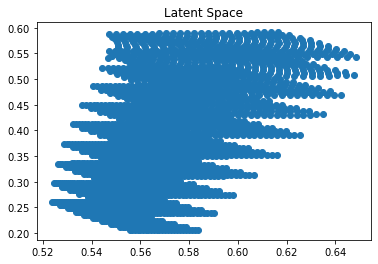

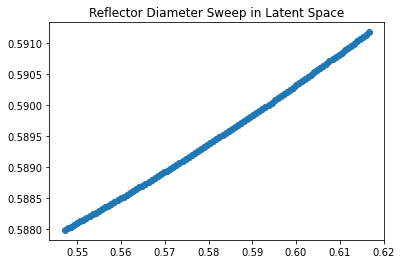

In [70]:
from matplotlib import pyplot as plt

diameterSweep = torch.tensor([[x, minFeatures[1],minFeatures[2]] for x in torch.linspace(minFeatures[0],maxFeatures[0],100)])

latent = model.encode(features)


diameterSweepLatent = model.encode(diameterSweep).detach().numpy()


plt.figure()
plt.title('Latent Space')
plt.scatter(latent[:,0].detach().numpy(),latent[:,1].detach().numpy())

plt.figure()
plt.title('Reflector Diameter Sweep in Latent Space')
plt.scatter(diameterSweepLatent[:,0],diameterSweepLatent[:,1])